In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize to [0, 1] and reshape to (28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [4]:
# Encoder
input_img = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Bottleneck shape: (7, 7, 16)
# Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    x_train_noisy, x_train,  # noisy input, clean target
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 123s 254ms/step - loss: 0.3856 - val_loss: 0.3054
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 111s 236ms/step - loss: 0.3010 - val_loss: 0.3011
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 145s 242ms/step - loss: 0.2971 - val_loss: 0.2973
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 239ms/step - loss: 0.2950 - val_loss: 0.2952
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 237ms/step - loss: 0.2925 - val_loss: 0.2936
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 240ms/step - loss: 0.2913 - val_loss: 0.2926
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 241ms/step - loss: 0.2896 - val_loss: 0.2916
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 137s 229ms/step - loss: 0.2892 - val_loss: 0.2909
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 231ms/step - loss: 0.2883 - val_loss: 0.2908
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 108s 230ms/step - loss: 0.2879 - val_loss: 0.2897
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 230ms/step - loss: 0.2877 - val_loss: 0.2889
Epoch 12

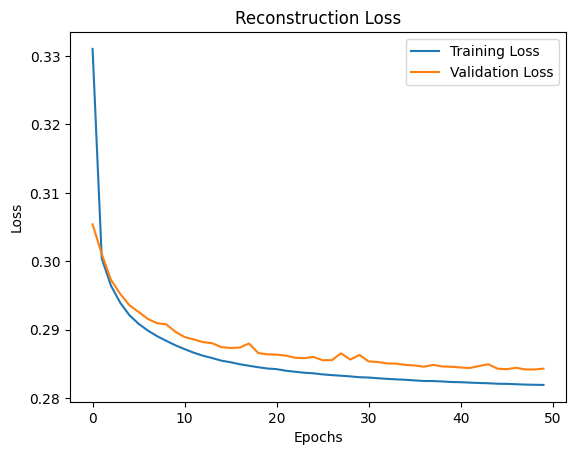

In [6]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Reconstruction Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


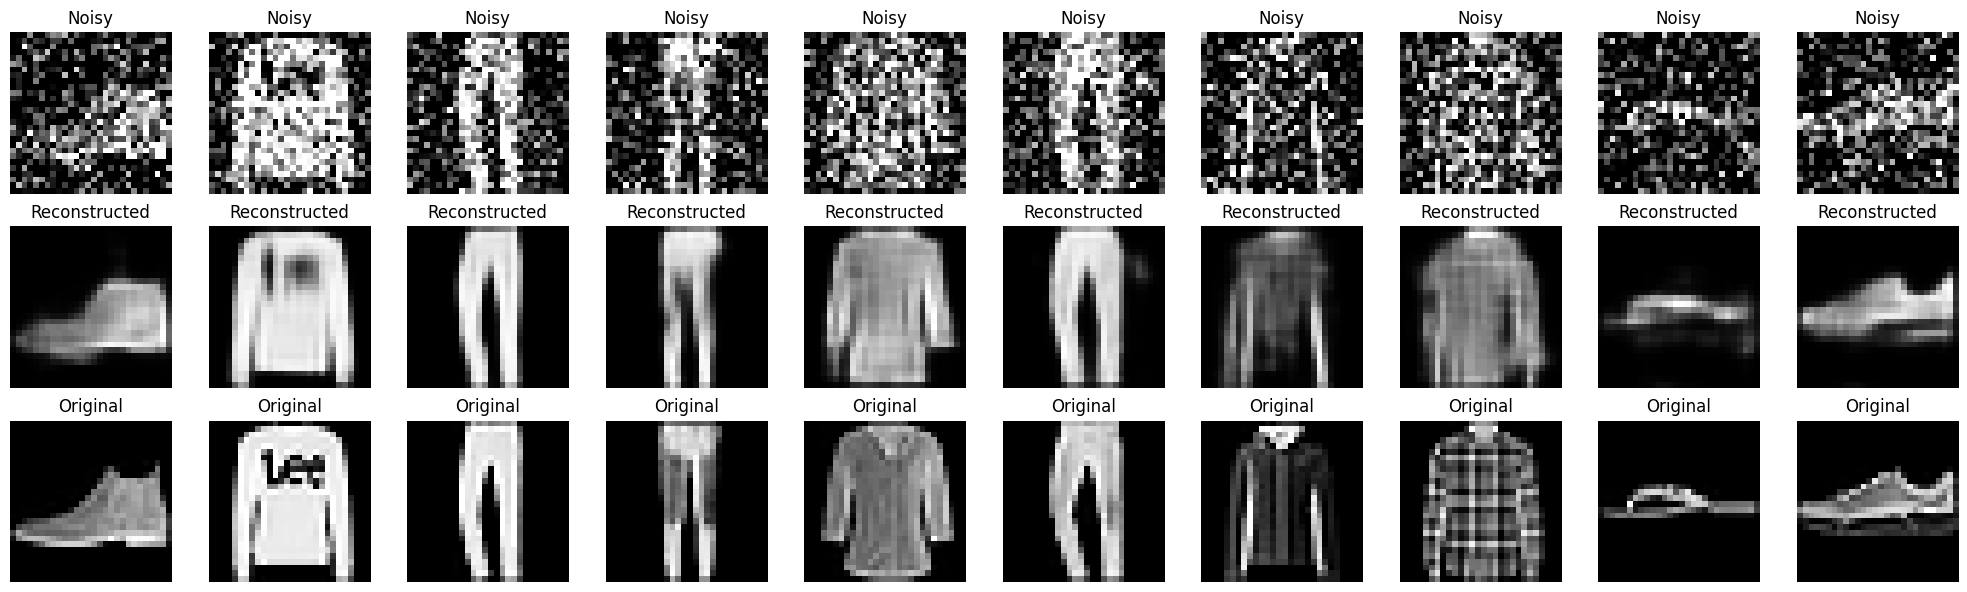

In [7]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Noisy Input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis("off")

    # Reconstructed Output
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")

    # Original Image
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")
plt.tight_layout()
plt.show()
